<a href="https://colab.research.google.com/github/safari-mohammadreza/MWL_MachineLearning/blob/main/FeatureSelectionMWLPaper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize

## Import section

In [ ]:
from scipy.stats import ttest_ind,ranksums
import numpy as np
import glob
import seaborn as sns
import pandas as pd
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
# from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut,KFold
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import KernelPCA,PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
import networkx as nx
from sklearn.model_selection import GridSearchCV
from collections import OrderedDict
from sklearn.naive_bayes import GaussianNB
import math
from sklearn.metrics import precision_recall_fscore_support
import os
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pickle

# !pip install numpy Cython
# !pip install -U pymrmr
# !pip install jupyternotify

# %config Completer.use_jedi = False
# pd.set_option('precision', 3)
# np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [ ]:
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

<IPython.core.display.Javascript object>

## Define some constants

In [ ]:
save_plot=True
save_edge=False
con_type='dDTF'
n_top=30
n_avg=2
condition=''
path='/content/gdrive/My Drive/your_path'
save_path='/content/gdrive/My Drive/your_path/save/'
save_fig='/content/gdrive/My Drive/your_path/figure/'

models=['svm','lda','rf','dt']
bands=['delta','theta','alpha','beta','gamma','top150']

index_arr = [["delta", "theta", "alpha", "beta", "gamma",'top150'], ["svm", "lda","rf","dt"]]

# creating dataframe of 'results' for each model, each freq. band and two conditions: with FS(feature selection) and without FS
index = pd.MultiIndex.from_product(index_arr, names=["Band", "Model"])
display(index)

col_arr=[["Without FS", "With FS"],["Accuracy", "Precision","Recall","F1-Measure"]]
col_index=pd.MultiIndex.from_product(col_arr, names=[" ", " "])
display(col_index)

results=pd.DataFrame(np.nan,index=index,columns=col_index)
results=results.astype(str)
display(results)

## Define some functions

### Classifiers functions

In [ ]:
def lda(df,print_results=True):
    data=df.to_numpy()
    X=data[:,:-1]
    y=data[:,-1] # extract last column of data as the 'label'
    kf = KFold(n_splits=7,shuffle=True,random_state=0)
    all_acc=[]
    all_precision=[]
    all_recall=[]
    all_f1=[]
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        scaler = StandardScaler()
        X_train=scaler.fit_transform(X_train)
        X_test=scaler.transform(X_test)
        clf = LinearDiscriminantAnalysis(solver='lsqr')
        clf.fit(X_train, y_train)
        precision, recall, f1, _=precision_recall_fscore_support(y_test, clf.predict(X_test), average='binary')
        all_acc.append(accuracy_score(y_test,clf.predict(X_test)))
        all_precision.append(precision)
        all_recall.append(recall)
        all_f1.append(f1)
    # results
    all_acc=np.array(all_acc)
    all_precision=np.array(all_precision)
    all_recall=np.array(all_recall)
    all_f1=np.array(all_f1)
    if print_results:
        print("Accuracy LDA: ",all_acc.mean())
    return all_acc, all_precision, all_recall, all_f1

In [ ]:
def svm_mean_kfold(df,print_results=True):
    data=df.to_numpy()
    X=data[:,:-1]
    y=data[:,-1]
    kf = KFold(n_splits=7,shuffle=True,random_state=0)
    all_acc=[]
    all_precision=[]
    all_recall=[]
    all_f1=[]
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        scaler = StandardScaler()
        X_train=scaler.fit_transform(X_train)
        X_test=scaler.transform(X_test)
        clf = SVC(random_state=0, probability=True)
        clf.fit(X_train, y_train)
        precision, recall, f1, _=precision_recall_fscore_support(y_test, clf.predict(X_test), average='binary')
        all_acc.append(accuracy_score(y_test,clf.predict(X_test)))

    # results
    all_acc=np.array(all_acc)
    return all_acc.mean()

In [ ]:
def svm(df,print_results=True):
    data=df.to_numpy()
    X=data[:,:-1]
    y=data[:,-1]
    kf = KFold(n_splits=7,shuffle=True,random_state=0)
    all_acc=[]
    all_precision=[]
    all_recall=[]
    all_f1=[]
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        scaler = StandardScaler()
        X_train=scaler.fit_transform(X_train)
        X_test=scaler.transform(X_test)
        clf = SVC(random_state=0, probability=True)
        clf.fit(X_train, y_train)
        precision, recall, f1, _=precision_recall_fscore_support(y_test, clf.predict(X_test), average='binary')
        all_acc.append(accuracy_score(y_test,clf.predict(X_test)))
        all_precision.append(precision)
        all_recall.append(recall)
        all_f1.append(f1)
    # results
    all_acc=np.array(all_acc)
    all_precision=np.array(all_precision)
    all_recall=np.array(all_recall)
    all_f1=np.array(all_f1)
    if print_results:
        print("Accuracy SVM: ",all_acc.mean())
    return all_acc, all_precision, all_recall, all_f1

In [ ]:
def rf(df,print_results=True): # random forest
    data=df.to_numpy()
    X=data[:,:-1]
    y=data[:,-1]
    kf = KFold(n_splits=7,shuffle=True,random_state=0)
    all_acc=[]
    all_precision=[]
    all_recall=[]
    all_f1=[]
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = RandomForestClassifier(random_state=0)
        clf.fit(X_train, y_train)
        precision, recall, f1, _=precision_recall_fscore_support(y_test, clf.predict(X_test), average='binary')
        all_acc.append(accuracy_score(y_test,clf.predict(X_test)))
        all_precision.append(precision)
        all_recall.append(recall)
        all_f1.append(f1)
    # results
    all_acc=np.array(all_acc)
    all_precision=np.array(all_precision)
    all_recall=np.array(all_recall)
    all_f1=np.array(all_f1)
    if print_results:
        print("Accuracy RF: ",all_acc.mean())
    return all_acc, all_precision, all_recall, all_f1

In [ ]:
def dt(df,print_results=True): # decision tree
    data=df.to_numpy()
    X=data[:,:-1]
    y=data[:,-1]
    kf = KFold(n_splits=7,shuffle=True,random_state=0)
    all_acc=[]
    all_precision=[]
    all_recall=[]
    all_f1=[]
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        clf = DecisionTreeClassifier(random_state=0,
                                    criterion='entropy', max_depth=22, min_samples_leaf=8)
        clf.fit(X_train, y_train)
        precision, recall, f1, _=precision_recall_fscore_support(y_test, clf.predict(X_test), average='binary')
        all_acc.append(accuracy_score(y_test,clf.predict(X_test)))
        all_precision.append(precision)
        all_recall.append(recall)
        all_f1.append(f1)
    # results
    all_acc=np.array(all_acc)
    all_precision=np.array(all_precision)
    all_recall=np.array(all_recall)
    all_f1=np.array(all_f1)
    if print_results:
        print("Accuracy DT: ",all_acc.mean())
    return all_acc, all_precision, all_recall, all_f1

In [ ]:
def lr(df):  #logestic regression
    data=df.to_numpy()
    X=data[:,:-1]
    y=data[:,-1]
    kf = KFold(n_splits=7,shuffle=True,random_state=0)
    all_auc=[]
    all_acc=[]
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        scaler = StandardScaler()
        X_train=scaler.fit_transform(X_train)
        X_test=scaler.transform(X_test)
        clf = LogisticRegression()
        clf.fit(X_train, y_train)
        all_acc.append(accuracy_score(y_test,clf.predict(X_test)))
        all_auc.append(roc_auc_score(y_test,clf.predict_proba(X_test)[:,1]))
    # results
    all_auc=np.array(all_auc).mean()
    all_acc=np.array(all_acc).mean()
#     print("Accuracy LR: ",all_acc)
#     print("AUC LR: ",all_auc)
    return all_acc, all_auc

In [ ]:
def rf_with_fs(df): #random forest with feature selection (top n features (n=30))
    ls_feature=list(df.columns[:-1])
    best_acc=-np.inf
    selected_features=[]
    best_feature=None
    df_results=pd.DataFrame([])
    c=0
    for n_comb in range(len(ls_feature)):
        best_current=0
        acc_current=None
        feature_current=None
        to_be_selected=None
        for feature in ls_feature:
            selected_features.append(feature)
            acc_current, _, _, _=rf(df[selected_features+['label']],print_results=False)
            acc_current=acc_current.mean()
            df_results=df_results.append({'Features':n_comb,'Accouracy':acc_current},ignore_index=True)
#             print(selected_features)
            if best_current<acc_current:
                best_current=acc_current
                to_be_selected=feature
            selected_features.remove(feature)
        selected_features.append(to_be_selected)
        ls_feature.remove(to_be_selected)
        if best_acc<best_current:
            best_acc=best_current
            best_feature=selected_features[:]
            c+=1
            print(f"feature{c}: {to_be_selected}")
            print("ACC Updated:",best_acc)
    return best_feature,df_results

In [ ]:
def lda_with_fs(df):
    ls_feature=list(df.columns[:-1])
    best_acc=-np.inf
    selected_features=[]
    best_feature=None
    df_results=pd.DataFrame([])
    for n_comb in range(len(ls_feature)):
        best_current=0
        acc_current=None
        feature_current=None
        to_be_selected=None
        for feature in ls_feature:
            selected_features.append(feature)
            acc_current, _, _, _=lda(df[selected_features+['label']],print_results=False)
            acc_current=acc_current.mean()
            df_results=df_results.append({'Features':n_comb,'Accouracy':acc_current},ignore_index=True)
#             print(selected_features)
            if best_current<acc_current:
                best_current=acc_current
                to_be_selected=feature
            selected_features.remove(feature)
        selected_features.append(to_be_selected)
        ls_feature.remove(to_be_selected)
        if best_acc<best_current:
            best_acc=best_current
            best_feature=selected_features[:]
            print("ACC Updated:",best_acc)
    return best_feature,df_results

In [ ]:
def dt_with_fs(df):
    ls_feature=list(df.columns[:-1])
    best_acc=-np.inf
    selected_features=[]
    best_feature=None
    df_results=pd.DataFrame([])
    for n_comb in range(len(ls_feature)):
        best_current=0
        acc_current=None
        feature_current=None
        to_be_selected=None
        for feature in ls_feature:
            selected_features.append(feature)
            acc_current, _, _, _=dt(df[selected_features+['label']],print_results=False)
            acc_current=acc_current.mean()
            df_results=df_results.append({'Features':n_comb,'Accouracy':acc_current},ignore_index=True)
#             print(selected_features)
            if best_current<acc_current:
                best_current=acc_current
                to_be_selected=feature
            selected_features.remove(feature)
        selected_features.append(to_be_selected)
        ls_feature.remove(to_be_selected)
        if best_acc<best_current:
            best_acc=best_current
            best_feature=selected_features[:]
            print("ACC Updated:",best_acc)
    return best_feature,df_results

In [ ]:
def svm_with_fs(df):
    ls_feature=list(df.columns[:-1])
    best_acc=-np.inf
    selected_features=[]
    best_feature=None
    df_results=pd.DataFrame([])
    c=0
    for n_comb in range(len(ls_feature)):
        best_current=0
        acc_current=None
        feature_current=None
        to_be_selected=None
        for feature in ls_feature:
            selected_features.append(feature)
            acc_current, _, _, _=svm(df[selected_features+['label']],print_results=False)
            acc_current=acc_current.mean()
            df_results=df_results.append({'Features':n_comb,'Accouracy':acc_current},ignore_index=True)
#             print(selected_features)
            if best_current<acc_current:
                best_current=acc_current
                to_be_selected=feature
            selected_features.remove(feature)
        selected_features.append(to_be_selected)
        ls_feature.remove(to_be_selected)
        if best_acc<best_current:
            best_acc=best_current
            best_feature=selected_features[:]
            c+=1
            print(f"feature{c}: {to_be_selected}")
            print("ACC Updated:",best_acc)
    return best_feature,df_results

### Other functions

In [ ]:
def read_mat(path, freq_band='alpha'):
    number_of_segments=37
    number_of_users=48
    hi_counter=0
    lo_counter=0
    hi_data=np.zeros((number_of_users*number_of_segments,14,14)) # sub=48, win_num=37
    lo_data=np.zeros((number_of_users*number_of_segments,14,14))
    for subject_number in range(number_of_users):
      for segment in range(number_of_segments):
        path_subejct = path + "dDTF_s" + str(subject_number+1) + "_hi_" + freq_band + str(segment+1) + ".mat"
        ddtf=scipy.io.loadmat(path_subejct)['needToSave']
        hi_data[hi_counter,:,:]=ddtf
        hi_counter+=1
      for segment in range(number_of_segments):
        path_subejct = path + "dDTF_s" + str(subject_number+1) + "_lo_" + freq_band + str(segment+1) + ".mat"
        ddtf=scipy.io.loadmat(path_subejct)['needToSave']
        lo_data[lo_counter,:,:]=ddtf
        lo_counter+=1
    return hi_data, lo_data

In [ ]:
def plot_mean_index(mean_index, label, vmin, vmax, save_path, save_plot=False,cmap='jet'):
    df_p_value = pd.DataFrame(mean_index, columns=label, index=label)
    f = sns.heatmap(df_p_value, cmap=cmap, vmin=vmin, vmax=vmax)
    # cbar = f.collections[0].colorbar
    # cbar.set_ticks([1, 30])
    # cbar.set_ticklabels(['Rank 30', 'Rank1'])
    if save_plot:
        f.figure.savefig(save_path + ".png", dpi=600)
    plt.show()

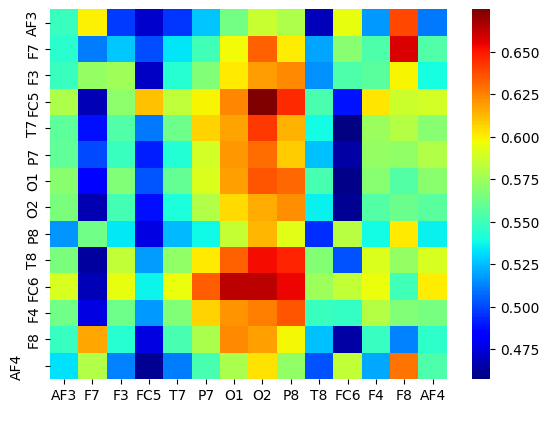

In [ ]:
def plot_connectivity(auc_mat,label,save_path,ntop_features=30,save_edge=False,save_plot=False): # auc_mat=auc_mat_delta.flatten it's shape: (14*14,)=(196,)
    df_con=pd.DataFrame(auc_mat,columns=['auc']) # result's shape: (196,1) - the column got label: 'auc'
    df_con.reset_index(inplace=True) # result's shape: (196,2) - a column added named: index from 0to195
    df_con.rename(columns={'index':'position'},inplace=True) # index column renamed to: position
    df_con['x']=df_con['position']//14 # result's shape: (196,3) - a column added named: x from 0to13 that is quotient of 14
    df_con['y']=df_con['position']%14 # result's shape: (196,4) - a column added named: y from 0to13 that is reminder of 14
    df_con=df_con.sort_values('auc',ascending=False,ignore_index=True).reset_index() # result's shape: (196,5) - a column added named: index from 0to195 - rows are sorted desc by 'auc' column
    df_con.rename(columns={'index':'rank'},inplace=True) # index column renamed to: rank
    # df_con=df_con.iloc[:ntop_features] # select top 30 rows (features) - result's shape: (30, 5)
    conn_mat=np.zeros((14*14))
    conn_mat[df_con['position']]=df_con['auc'] # based on position's value, set value of auc to conn_mat and then reshape conn_mat to: (14, 14)
    conn_mat=conn_mat.reshape(14,14)
    conn_mat[conn_mat==0]=np.nan
    plot_mean_index(conn_mat,label,np.nanmin(conn_mat),np.nanmax(conn_mat),save_path,save_plot)
    if save_edge:
        conn_mat=np.where(np.isnan(conn_mat),int(0),conn_mat)
        np.savetxt(r''+ save_path + '.edge', conn_mat.T, delimiter='\t')
    return np.where(np.isnan(conn_mat),0,conn_mat) # result's shape: (14,14) - result is a 14,14 matrix that only top-30-auc-based connectivities has value.

con=plot_connectivity(auc_mat_alpha.flatten(),label,save_path+'alpha_auc',save_edge=save_edge,save_plot=save_plot)

In [ ]:
def prepare_data(indices,np_hi,np_lo,col_name=None):
    np_hi=pd.DataFrame(np_hi.reshape(np_hi.shape[0],-1)[:,indices]) # initial_shape: (888, 14, 14) --- result_shape: (888, 1)
    np_lo=pd.DataFrame(np_lo.reshape(np_lo.shape[0],-1)[:,indices])
    np_hi['label']=1 # shape: (888, 2)
    np_lo['label']=0
    df_data=pd.concat([np_hi,np_lo],axis=0,ignore_index=True) #vertically concatenation. result shape: (1776, 2)
    if col_name!=None:
      df_data.set_axis(col_name + ['label'], axis=1, inplace=True)
    return df_data

In [ ]:
def connectivity(auc_mat,label,save_path,ntop_features=30,save_edge=False,save_plot=False): # auc_mat=auc_mat_delta.flatten it's shape: (14*14,)=(196,)
    df_con=pd.DataFrame(auc_mat,columns=['auc']) # result's shape: (196,1) - the column got label: 'auc'
    df_con.reset_index(inplace=True) # result's shape: (196,2) - a column added named: index from 0to195
    df_con.rename(columns={'index':'position'},inplace=True) # index column renamed to: position
    df_con['x']=df_con['position']//14 # result's shape: (196,3) - a column added named: x from 0to13 that is quotient of 14
    df_con['y']=df_con['position']%14 # result's shape: (196,4) - a column added named: y from 0to13 that is reminder of 14
    df_con=df_con.sort_values('auc',ascending=False,ignore_index=True).reset_index() # result's shape: (196,5) - a column added named: index from 0to195 - rows are sorted desc by 'auc' column
    df_con.rename(columns={'index':'rank'},inplace=True) # index column renamed to: rank
    df_con=df_con.iloc[:ntop_features] # select top 30 rows (features) - result's shape: (30, 5)
    conn_mat=np.zeros((14*14))
    conn_mat[df_con['position']]=df_con['auc'] # based on position's value, set value of auc to conn_mat and then reshape conn_mat to: (14, 14)
    conn_mat=conn_mat.reshape(14,14)
    conn_mat[conn_mat==0]=np.nan
    plot_mean_index(conn_mat,label,np.nanmin(conn_mat),np.nanmax(conn_mat),save_path,save_plot)
    if save_edge:
        conn_mat=np.where(np.isnan(conn_mat),int(0),conn_mat)
        np.savetxt(r''+ save_path + '.edge', conn_mat.T, delimiter='\t')
    return np.where(np.isnan(conn_mat),0,conn_mat) # result's shape: (14,14) - result is a 14,14 matrix that only top-30-auc-based connectivities has value.

In [ ]:
def p_value(hi,lo):
  p_mat=np.zeros((14,14))
  for i in range(14):
    for j in range(14):
      stat,p=ttest_ind(hi[:,i,j],lo[:,i,j])
      p_mat[i,j]=p
  return p_mat

In [ ]:
def get_min(data):
  min_value=np.inf
  for n in range(data.shape[0]):
    for i in range(data.shape[1]):
      for j in range(data.shape[2]):
        if i==j:
          continue
        if data[n,i,j] < min_value:
          min_value = data[n,i,j]
  return min_value

In [ ]:
def get_max(data):
    max_value=-np.inf
    for n in range(data.shape[0]):
        for i in range(data.shape[1]):
            for j in range(data.shape[2]):
                if i==j:
                    continue
                if data[n,i,j] > max_value:
                    max_value = data[n,i,j]
        return max_value

In [ ]:
def min_max_two_group(group_one, group_two):

    min_one = get_min(group_one)
    min_two = get_min(group_two)

    if min_one <= min_two:
        min_value = min_one
    else:
        min_value = min_two

    max_one = get_max(group_one)
    max_two = get_max(group_two)

    if max_one >= max_two:
        max_value = max_one
    else:
        max_value = max_two

    return min_value, max_value

In [ ]:
def normalization(data, min_value, max_value):
    zero_diag=1-np.eye(14,14)
    data=(data-min_value)/(max_value-min_value)
    for i in range(data.shape[0]):
        data[i,:,:]=data[i,:,:]*zero_diag
    return data

In [ ]:
def top_n_value(matrix,kth,smallest=True):
    if smallest:
        idx = np.argpartition(matrix, kth)
        matrix[matrix>max(matrix[idx[:kth]])]=np.nan
    else:
        idx = np.argpartition(matrix, -kth)
        matrix[matrix<min(matrix[idx[-kth:]])]=np.nan
    return matrix

In [ ]:
def create_df_connectivity(x,y,auc,pval,label,num_connections,sort_by='AUC'): # Create DataFrame connectivity
    data=[]
    for i in range(num_connections):
        data.append([label[int(x[i])]] + [label[int(y[i])]]+ [(auc[int(x[i]),int(y[i])])] + [pval[int(x[i]),int(y[i])]])
    df=pd.DataFrame(data,columns=['From','To','AUC','P value'])
    if sort_by=='AUC':
        df=df.sort_values(sort_by,ascending=False,ignore_index=True)
    else:
        df=df.sort_values(sort_by,ascending=True,ignore_index=True)
    return df

In [ ]:
def num_tree(data):
    ensemble_clfs = [ ("RandomForestClassifier, max_features=None",RandomForestClassifier(warm_start=True, max_features=None, oob_score=True,))]

    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

    min_estimators = 10
    max_estimators = 300

    for label, clf in ensemble_clfs:
        for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(data[:,:-1], data[:,-1])
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))

    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()

In [ ]:
def plot_results(df_result,path,save_plot=False):
    fig = df_result.boxplot(by='Features',figsize=(30,26)).get_figure()
    fig.savefig(f'{path}.png',dpi=600)

## Load data

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# channels' label/name
with open ("/content/gdrive/My Drive/your_path/channels_name.txt", "r") as myfile:
    label=myfile.read().split(' ')
print(label)

In [ ]:
# %%notify
# hi_delta, lo_delta = read_mat(path,'delta')
# hi_theta, lo_theta = read_mat(path,'theta')
# hi_alpha, lo_alpha = read_mat(path,'alpha')
# hi_beta, lo_beta = read_mat(path,'beta')
# hi_gamma, lo_gamma = read_mat(path,'gamma')

# print(np.shape(hi_delta))
# print(np.shape(lo_delta))
# print(np.shape(hi_theta))
# print(np.shape(lo_theta))
# print(np.shape(hi_delta))
# print(np.shape(lo_delta))
# print(np.shape(hi_delta))
# print(np.shape(lo_delta))
# print(np.shape(hi_delta))
# print(np.shape(lo_delta))


# with open(path+'hi_delta', 'wb') as file_pi1:
#     pickle.dump(hi_delta, file_pi1)
# with open(path+'lo_delta', 'wb') as file_pi1:
#     pickle.dump(lo_delta, file_pi1)

# with open(path+'hi_theta', 'wb') as file_pi1:
#     pickle.dump(hi_theta, file_pi1)
# with open(path+'lo_theta', 'wb') as file_pi1:
#     pickle.dump(lo_theta, file_pi1)

# with open(path+'hi_alpha', 'wb') as file_pi1:
#     pickle.dump(hi_alpha, file_pi1)
# with open(path+'lo_alpha', 'wb') as file_pi1:
#     pickle.dump(lo_alpha, file_pi1)

# with open(path+'hi_beta', 'wb') as file_pi1:
#     pickle.dump(hi_beta, file_pi1)
# with open(path+'lo_beta', 'wb') as file_pi1:
#     pickle.dump(lo_beta, file_pi1)

# with open(path+'hi_gamma', 'wb') as file_pi1:
#     pickle.dump(hi_gamma, file_pi1)
# with open(path+'lo_gamma', 'wb') as file_pi1:
#     pickle.dump(lo_gamma, file_pi1)


In [ ]:
with open(path+'hi_delta', 'rb') as f:
    hi_delta = pickle.load(f)
print(np.shape(hi_delta)) # (1776, 14, 14)
with open(path+'lo_delta', 'rb') as f:
    lo_delta = pickle.load(f)
print(np.shape(lo_delta))

with open(path+'hi_theta', 'rb') as f:
    hi_theta = pickle.load(f)
print(np.shape(hi_theta))
with open(path+'lo_theta', 'rb') as f:
    lo_theta = pickle.load(f)
print(np.shape(lo_theta))

with open(path+'hi_alpha', 'rb') as f:
    hi_alpha = pickle.load(f)
print(np.shape(hi_alpha))
with open(path+'lo_alpha', 'rb') as f:
    lo_alpha = pickle.load(f)
print(np.shape(lo_alpha))

with open(path+'hi_beta', 'rb') as f:
    hi_beta = pickle.load(f)
print(np.shape(hi_beta))
with open(path+'lo_beta', 'rb') as f:
    lo_beta = pickle.load(f)
print(np.shape(lo_beta))

with open(path+'hi_gamma', 'rb') as f:
    hi_gamma = pickle.load(f)
print(np.shape(hi_gamma))
with open(path+'lo_gamma', 'rb') as f:
    lo_gamma = pickle.load(f)
print(np.shape(lo_gamma))

## Averaging

In [ ]:
# In order to decrease processing
# averaging every n element
hi_delta=hi_delta.reshape(-1,n_avg,14,14).mean(axis=1)
hi_theta=hi_theta.reshape(-1,n_avg,14,14).mean(axis=1)
hi_alpha=hi_alpha.reshape(-1,n_avg,14,14).mean(axis=1)
hi_beta=hi_beta.reshape(-1,n_avg,14,14).mean(axis=1)
hi_gamma=hi_gamma.reshape(-1,n_avg,14,14).mean(axis=1)

print(np.shape(hi_delta))

(888, 14, 14)


In [ ]:
lo_delta=lo_delta.reshape(-1,n_avg,14,14).mean(axis=1)
lo_theta=lo_theta.reshape(-1,n_avg,14,14).mean(axis=1)
lo_alpha=lo_alpha.reshape(-1,n_avg,14,14).mean(axis=1)
lo_beta=lo_beta.reshape(-1,n_avg,14,14).mean(axis=1)
lo_gamma=lo_gamma.reshape(-1,n_avg,14,14).mean(axis=1)

# Feature Selection

## Forward Feature Selection

### Delta

In [ ]:
%%notify
auc_mat_delta = np.zeros(14*14)
for i in range(14*14): # iterate over all cells of a connectivity mat file. // 'i' indicates a connectivity between two channels.
    df = prepare_data(i,(hi_delta),(lo_delta)) #shape df: (1776,2)
    acc,auc=lr(df)
    auc_mat_delta[i]=auc
auc_mat_delta=auc_mat_delta.reshape(14,14)

In [ ]:
con=connectivity(auc_mat_delta.flatten(), label, save_path+'delta_auc', n_top, save_edge=save_edge, save_plot=save_plot) # the result is a (14,14) matrix that only top-30-auc-based indices has value and the value is their auc.
index_delta=np.where(con.flatten()>0)[0]
x=index_delta//14
y=index_delta%14
col_name=[label[int(x[i])] + "=>" + label[int(y[i])] for i in range(len(x))] # the result is channels' name in n-top connectivities.
print(col_name)

In [ ]:
df = prepare_data(index_delta,hi_delta,lo_delta,col_name)
display(df) # the result is a dataframe with 30 columns (top-30 connectivities) and 1776 rows

In [ ]:
# preforming feature selection for every model //////////////////TIME_CONSUMING
for model in models:
    exec(f"feature_{model}_delta,df_resutls_{model}_delta={model}_with_fs(df)")
    print(10*'-')

In [ ]:
# classification with selected features
for model in models:
    exec(f"acc, precision, recall, f1={model}(df[feature_{model}_delta + ['label']])")
    exec(f"results.loc[('delta','{model}')]['With FS','Accuracy']=str('%.2f' % (acc.mean()*100)) + '%' + ' (±' + str('%.2f' % (acc.std()*100)) + ')'")
    exec(f"results.loc[('delta','{model}')]['With FS','Precision']=str('%.2f' % (precision.mean()*100)) + '%' + ' (±' + str('%.2f' % (precision.std()*100)) + ')'")
    exec(f"results.loc[('delta','{model}')]['With FS','Recall']=str('%.2f' % (recall.mean()*100)) + '%' + ' (±' + str('%.2f' % (recall.std()*100)) + ')'")
    exec(f"results.loc[('delta','{model}')]['With FS','F1-Measure']=str('%.2f' % (f1.mean()*100)) + '%' + ' (±' + str('%.2f' % ((f1.std()*100))) + ')'")
    print(10*'-')

In [ ]:
# classificaiton with all features
for model in models:
    exec(f"acc, precision, recall, f1={model}(df)")
    exec(f"results.loc[('delta','{model}')]['Without FS','Accuracy']=str('%.2f' % (acc.mean()*100)) + '%' + ' (±' + str('%.2f' % (acc.std()*100)) + ')'")
    exec(f"results.loc[('delta','{model}')]['Without FS','Precision']=str('%.2f' % (precision.mean()*100)) + '%' + ' (±' + str('%.2f' % (precision.std()*100)) + ')'")
    exec(f"results.loc[('delta','{model}')]['Without FS','Recall']=str('%.2f' % (recall.mean()*100)) + '%' + ' (±' + str('%.2f' % (recall.std()*100)) + ')'")
    exec(f"results.loc[('delta','{model}')]['Without FS','F1-Measure']=str('%.2f' % (f1.mean()*100)) + '%' + ' (±' + str('%.2f' % ((f1.std()*100))) + ')'")
    print(10*'-')

### Theta

In [ ]:
%%notify
auc_mat_theta = np.zeros(14*14)
for i in range(14*14):
    df = prepare_data(i,(hi_theta),(lo_theta))
    acc,auc=lr(df)
    auc_mat_theta[i]=auc
auc_mat_theta=auc_mat_theta.reshape(14,14)

<IPython.core.display.Javascript object>

In [ ]:
con=connectivity(auc_mat_theta.flatten(),label,save_path+'theta_auc',save_edge=save_edge,save_plot=save_plot)
index_theta=np.where(con.flatten()>0)[0]
x=index_theta//14
y=index_theta%14
col_name=[label[int(x[i])] + "=>" + label[int(y[i])] for i in range(len(x))]

In [ ]:
df = prepare_data(index_theta,hi_theta,lo_theta,col_name)

In [ ]:
# preforming feature selection for every model //////////////////TIME_CONSUMING
for model in models:
    exec(f"feature_{model}_theta,df_resutls_{model}_theta={model}_with_fs(df)")
    print(10*'-')

In [ ]:
# classification with selected features
for model in models:
    exec(f"acc, precision, recall, f1={model}(df[feature_{model}_theta + ['label']])")
    exec(f"results.loc[('theta','{model}')]['With FS','Accuracy']=str('%.2f' % (acc.mean()*100)) + '%' + ' (±' + str('%.2f' % (acc.std()*100)) + ')'")
    exec(f"results.loc[('theta','{model}')]['With FS','Precision']=str('%.2f' % (precision.mean()*100)) + '%' + ' (±' + str('%.2f' % (precision.std()*100)) + ')'")
    exec(f"results.loc[('theta','{model}')]['With FS','Recall']=str('%.2f' % (recall.mean()*100)) + '%' + ' (±' + str('%.2f' % (recall.std()*100)) + ')'")
    exec(f"results.loc[('theta','{model}')]['With FS','F1-Measure']=str('%.2f' % (f1.mean()*100)) + '%' + ' (±' + str('%.2f' % ((f1.std()*100))) + ')'")
    print(10*'-')

In [ ]:
# classificaiton with all features
for model in models:
    exec(f"acc, precision, recall, f1={model}(df)")
    exec(f"results.loc[('theta','{model}')]['Without FS','Accuracy']=str('%.2f' % (acc.mean()*100)) + '%' + ' (±' + str('%.2f' % (acc.std()*100)) + ')'")
    exec(f"results.loc[('theta','{model}')]['Without FS','Precision']=str('%.2f' % (precision.mean()*100)) + '%' + ' (±' + str('%.2f' % (precision.std()*100)) + ')'")
    exec(f"results.loc[('theta','{model}')]['Without FS','Recall']=str('%.2f' % (recall.mean()*100)) + '%' + ' (±' + str('%.2f' % (recall.std()*100)) + ')'")
    exec(f"results.loc[('theta','{model}')]['Without FS','F1-Measure']=str('%.2f' % (f1.mean()*100)) + '%' + ' (±' + str('%.2f' % ((f1.std()*100))) + ')'")
    print(10*'-')

### Alpha

In [ ]:
# %%notify
auc_mat_alpha = np.zeros(14*14)
for i in range(14*14):
    df = prepare_data(i,(hi_alpha),(lo_alpha))
    acc,auc=lr(df)
    auc_mat_alpha[i]=auc
auc_mat_alpha=auc_mat_alpha.reshape(14,14)

In [ ]:
con=connectivity(auc_mat_alpha.flatten(),label,save_path+'alpha_auc',save_edge=save_edge,save_plot=save_plot)
index_alpha=np.where(con.flatten()>0)[0]
x=index_alpha//14
y=index_alpha%14
col_name=[label[int(x[i])] + "=>" + label[int(y[i])] for i in range(len(x))]

In [ ]:
df = prepare_data(index_alpha,hi_alpha,lo_alpha,col_name)

In [ ]:
# preforming feature selection for every model //////////////////TIME_CONSUMING
for model in models:
    exec(f"feature_{model}_alpha,df_resutls_{model}_alpha={model}_with_fs(df)")
    print(10*'-')t

In [ ]:
# classification with selected features
for model in models:
    exec(f"acc, precision, recall, f1={model}(df[feature_{model}_alpha + ['label']])")
    exec(f"results.loc[('alpha','{model}')]['With FS','Accuracy']=str('%.2f' % (acc.mean()*100)) + '%' + ' (±' + str('%.2f' % (acc.std()*100)) + ')'")
    exec(f"results.loc[('alpha','{model}')]['With FS','Precision']=str('%.2f' % (precision.mean()*100)) + '%' + ' (±' + str('%.2f' % (precision.std()*100)) + ')'")
    exec(f"results.loc[('alpha','{model}')]['With FS','Recall']=str('%.2f' % (recall.mean()*100)) + '%' + ' (±' + str('%.2f' % (recall.std()*100)) + ')'")
    exec(f"results.loc[('alpha','{model}')]['With FS','F1-Measure']=str('%.2f' % (f1.mean()*100)) + '%' + ' (±' + str('%.2f' % ((f1.std()*100))) + ')'")
    print(10*'-')

In [ ]:
# classificaiton with all features
for model in models:
    exec(f"acc, precision, recall, f1={model}(df)")
    exec(f"results.loc[('alpha','{model}')]['Without FS','Accuracy']=str('%.2f' % (acc.mean()*100)) + '%' + ' (±' + str('%.2f' % (acc.std()*100)) + ')'")
    exec(f"results.loc[('alpha','{model}')]['Without FS','Precision']=str('%.2f' % (precision.mean()*100)) + '%' + ' (±' + str('%.2f' % (precision.std()*100)) + ')'")
    exec(f"results.loc[('alpha','{model}')]['Without FS','Recall']=str('%.2f' % (recall.mean()*100)) + '%' + ' (±' + str('%.2f' % (recall.std()*100)) + ')'")
    exec(f"results.loc[('alpha','{model}')]['Without FS','F1-Measure']=str('%.2f' % (f1.mean()*100)) + '%' + ' (±' + str('%.2f' % ((f1.std()*100))) + ')'")
    print(10*'-')

### Beta

In [ ]:
%%notify
auc_mat_beta = np.zeros(14*14)
for i in range(14*14):
    df = prepare_data(i,(hi_beta),(lo_beta))
    acc,auc=lr(df)
    auc_mat_beta[i]=auc
auc_mat_beta=auc_mat_beta.reshape(14,14)

<IPython.core.display.Javascript object>

In [ ]:
con=connectivity(auc_mat_beta.flatten(),label,save_path+'beta_auc',save_edge=save_edge,save_plot=save_plot)
index_beta=np.where(con.flatten()>0)[0]
x=index_beta//14
y=index_beta%14
col_name=[label[int(x[i])] + "=>" + label[int(y[i])] for i in range(len(x))]

In [ ]:
df = prepare_data(index_beta,hi_beta,lo_beta,col_name)

In [ ]:
# preforming feature selection for every model //////////////////TIME_CONSUMING
for model in models:
    exec(f"feature_{model}_beta,df_resutls_{model}_beta={model}_with_fs(df)")
    print(10*'-')

In [ ]:
# classification with selected features
for model in models:
    exec(f"acc, precision, recall, f1={model}(df[feature_{model}_beta + ['label']])")
    exec(f"results.loc[('beta','{model}')]['With FS','Accuracy']=str('%.2f' % (acc.mean()*100)) + '%' + ' (±' + str('%.2f' % (acc.std()*100)) + ')'")
    exec(f"results.loc[('beta','{model}')]['With FS','Precision']=str('%.2f' % (precision.mean()*100)) + '%' + ' (±' + str('%.2f' % (precision.std()*100)) + ')'")
    exec(f"results.loc[('beta','{model}')]['With FS','Recall']=str('%.2f' % (recall.mean()*100)) + '%' + ' (±' + str('%.2f' % (recall.std()*100)) + ')'")
    exec(f"results.loc[('beta','{model}')]['With FS','F1-Measure']=str('%.2f' % (f1.mean()*100)) + '%' + ' (±' + str('%.2f' % ((f1.std()*100))) + ')'")
    print(10*'-')

In [ ]:
# classificaiton with all features
for model in models:
    exec(f"acc, precision, recall, f1={model}(df)")
    exec(f"results.loc[('beta','{model}')]['Without FS','Accuracy']=str('%.2f' % (acc.mean()*100)) + '%' + ' (±' + str('%.2f' % (acc.std()*100)) + ')'")
    exec(f"results.loc[('beta','{model}')]['Without FS','Precision']=str('%.2f' % (precision.mean()*100)) + '%' + ' (±' + str('%.2f' % (precision.std()*100)) + ')'")
    exec(f"results.loc[('beta','{model}')]['Without FS','Recall']=str('%.2f' % (recall.mean()*100)) + '%' + ' (±' + str('%.2f' % (recall.std()*100)) + ')'")
    exec(f"results.loc[('beta','{model}')]['Without FS','F1-Measure']=str('%.2f' % (f1.mean()*100)) + '%' + ' (±' + str('%.2f' % ((f1.std()*100))) + ')'")
    print(10*'-')

### Gamma

In [ ]:
%%notify
auc_mat_gamma = np.zeros(14*14)
for i in range(14*14):
    df = prepare_data(i,(hi_gamma),(lo_gamma))
    acc,auc=lr(df)
    auc_mat_gamma[i]=auc
auc_mat_gamma=auc_mat_gamma.reshape(14,14)

<IPython.core.display.Javascript object>

In [ ]:
con=connectivity(auc_mat_gamma.flatten(),label,save_path+'gamma_auc',save_edge=save_edge,save_plot=save_plot)
index_gamma=np.where(con.flatten()>0)[0]
x=index_gamma//14
y=index_gamma%14
col_name=[label[int(x[i])] + "=>" + label[int(y[i])] for i in range(len(x))]

In [ ]:
df = prepare_data(index_gamma,hi_gamma,lo_gamma,col_name)

In [ ]:
# preforming feature selection for every model //////////////////TIME_CONSUMING
for model in models:
    exec(f"feature_{model}_gamma,df_resutls_{model}_gamma={model}_with_fs(df)")
    print(10*'-')

In [ ]:
# classification with selected features
for model in models:
    exec(f"acc, precision, recall, f1={model}(df[feature_{model}_gamma + ['label']])")
    exec(f"results.loc[('gamma','{model}')]['With FS','Accuracy']=str('%.2f' % (acc.mean()*100)) + '%' + ' (±' + str('%.2f' % (acc.std()*100)) + ')'")
    exec(f"results.loc[('gamma','{model}')]['With FS','Precision']=str('%.2f' % (precision.mean()*100)) + '%' + ' (±' + str('%.2f' % (precision.std()*100)) + ')'")
    exec(f"results.loc[('gamma','{model}')]['With FS','Recall']=str('%.2f' % (recall.mean()*100)) + '%' + ' (±' + str('%.2f' % (recall.std()*100)) + ')'")
    exec(f"results.loc[('gamma','{model}')]['With FS','F1-Measure']=str('%.2f' % (f1.mean()*100)) + '%' + ' (±' + str('%.2f' % ((f1.std()*100))) + ')'")
    print(10*'-')

In [ ]:
# classificaiton with all features
for model in models:
    exec(f"acc, precision, recall, f1={model}(df)")
    exec(f"results.loc[('gamma','{model}')]['Without FS','Accuracy']=str('%.2f' % (acc.mean()*100)) + '%' + ' (±' + str('%.2f' % (acc.std()*100)) + ')'")
    exec(f"results.loc[('gamma','{model}')]['Without FS','Precision']=str('%.2f' % (precision.mean()*100)) + '%' + ' (±' + str('%.2f' % (precision.std()*100)) + ')'")
    exec(f"results.loc[('gamma','{model}')]['Without FS','Recall']=str('%.2f' % (recall.mean()*100)) + '%' + ' (±' + str('%.2f' % (recall.std()*100)) + ')'")
    exec(f"results.loc[('gamma','{model}')]['Without FS','F1-Measure']=str('%.2f' % (f1.mean()*100)) + '%' + ' (±' + str('%.2f' % ((f1.std()*100))) + ')'")
    print(10*'-')

### Top 150

Delta

In [ ]:
con=connectivity(auc_mat_delta.flatten(),label,save_path+'delta_auc',save_edge=save_edge,save_plot=save_plot)
index_delta=np.where(con.flatten()>0)[0]
x=index_delta//14
y=index_delta%14
col_name=[label[int(x[i])] + "=>" + label[int(y[i])] +" delta" for i in range(len(x))]

In [ ]:
df_delta = prepare_data(index_delta,hi_delta,lo_delta,col_name)
df_delta.drop('label',axis=1,inplace=True)

Theta

In [ ]:
con=connectivity(auc_mat_theta.flatten(),label,save_path+'theta_auc',save_edge=save_edge,save_plot=save_plot)
index_theta=np.where(con.flatten()>0)[0]
x=index_theta//14
y=index_theta%14
col_name=[label[int(x[i])] + "=>" + label[int(y[i])] +" theta" for i in range(len(x))]

In [ ]:
df_theta = prepare_data(index_theta,hi_theta,lo_theta,col_name)
df_theta.drop('label',axis=1,inplace=True)

Alpha

In [ ]:
con=connectivity(auc_mat_alpha.flatten(),label,save_path+'alpha_auc',save_edge=save_edge,save_plot=save_plot)
index_alpha=np.where(con.flatten()>0)[0]
x=index_alpha//14
y=index_alpha%14
col_name=[label[int(x[i])] + "=>" + label[int(y[i])] +" alpha" for i in range(len(x))]

In [ ]:
df_alpha = prepare_data(index_alpha,hi_alpha,lo_alpha,col_name)
df_alpha.drop('label',axis=1,inplace=True)

beta

In [ ]:
con=connectivity(auc_mat_beta.flatten(),label,save_path+'beta_auc',save_edge=save_edge,save_plot=save_plot)
index_beta=np.where(con.flatten()>0)[0]
x=index_beta//14
y=index_beta%14
col_name=[label[int(x[i])] + "=>" + label[int(y[i])] +" beta" for i in range(len(x))]

In [ ]:
df_beta = prepare_data(index_beta,hi_beta,lo_beta,col_name)
df_beta.drop('label',axis=1,inplace=True)

Gamma

In [ ]:
con=connectivity(auc_mat_gamma.flatten(),label,save_path+'gamma_auc',save_edge=save_edge,save_plot=save_plot)
index_gamma=np.where(con.flatten()>0)[0]
x=index_gamma//14
y=index_gamma%14
col_name=[label[int(x[i])] + "=>" + label[int(y[i])] +" gamma" for i in range(len(x))]

In [ ]:
df_gamma = prepare_data(index_gamma,hi_gamma,lo_gamma,col_name)

Top 150 (concat top-n features of all freq. bands)

In [ ]:
df_top150=pd.concat([df_delta,df_theta,df_alpha,df_beta,df_gamma],axis=1)

In [ ]:
from_column=[col.split('=>')[0] for col in df_top150.columns[:-1]]
to_column = [col.split('=>')[1].split(' ')[0] for col in df_top150.columns[:-1]]
df_electrods=pd.DataFrame({'From':from_column,'To':to_column})
df_electrods.groupby('To').count().sort_values('From',ascending=False)

In [ ]:
df_electrods.groupby('From').count().sort_values('To',ascending=False)

In [ ]:
df_top150.columns

In [ ]:
# preforming feature selection for every model //////////////////TIME_CONSUMING
for model in models:
    exec(f"feature_{model}_top150,df_resutls_{model}_top150={model}_with_fs(df_top150)")
    print(10*'-')

In [ ]:
# classification with selected features
for model in models:
    exec(f"acc, precision, recall, f1={model}(df_top150[feature_{model}_top150 + ['label']])")
    exec(f"results.loc[('top150','{model}')]['With FS','Accuracy']=str('%.2f' % (acc.mean()*100)) + '%' + ' (±' + str('%.2f' % (acc.std()*100)) + ')'")
    exec(f"results.loc[('top150','{model}')]['With FS','Precision']=str('%.2f' % (precision.mean()*100)) + '%' + ' (±' + str('%.2f' % (precision.std()*100)) + ')'")
    exec(f"results.loc[('top150','{model}')]['With FS','Recall']=str('%.2f' % (recall.mean()*100)) + '%' + ' (±' + str('%.2f' % (recall.std()*100)) + ')'")
    exec(f"results.loc[('top150','{model}')]['With FS','F1-Measure']=str('%.2f' % (f1.mean()*100)) + '%' + ' (±' + str('%.2f' % ((f1.std()*100))) + ')'")
    print(10*'-')

In [ ]:
# classificaiton with all features
for model in models:
    exec(f"acc, precision, recall, f1={model}(df_top150)")
    exec(f"results.loc[('top150','{model}')]['Without FS','Accuracy']=str('%.2f' % (acc.mean()*100)) + '%' + ' (±' + str('%.2f' % (acc.std()*100)) + ')'")
    exec(f"results.loc[('top150','{model}')]['Without FS','Precision']=str('%.2f' % (precision.mean()*100)) + '%' + ' (±' + str('%.2f' % (precision.std()*100)) + ')'")
    exec(f"results.loc[('top150','{model}')]['Without FS','Recall']=str('%.2f' % (recall.mean()*100)) + '%' + ' (±' + str('%.2f' % (recall.std()*100)) + ')'")
    exec(f"results.loc[('top150','{model}')]['Without FS','F1-Measure']=str('%.2f' % (f1.mean()*100)) + '%' + ' (±' + str('%.2f' % ((f1.std()*100))) + ')'")
    print(10*'-')

In [ ]:
results.loc[pd.IndexSlice[:, :], :].sort_values([("With FS","Accuracy")],ascending=False)

In [ ]:
results

Without FS                                                  \
                    Accuracy       Precision          Recall      F1-Measure   
Band   Model                                                                   
delta  svm    75.51% (±2.95)  74.19% (±3.04)  78.26% (±5.26)  76.09% (±3.37)   
       lda    72.64% (±3.59)  74.29% (±3.73)  69.12% (±5.45)  71.56% (±4.38)   
       rf     75.00% (±2.02)  74.09% (±1.50)  76.75% (±4.35)  75.36% (±2.76)   
       dt     67.45% (±2.09)  68.64% (±3.14)  64.61% (±2.99)  66.48% (±2.03)   
theta  svm    76.18% (±2.76)  77.21% (±3.19)  74.28% (±3.96)  75.68% (±3.17)   
       lda    71.29% (±2.95)  74.04% (±3.43)  65.37% (±5.06)  69.38% (±4.08)   
       rf     73.76% (±1.47)  73.07% (±1.92)  75.33% (±2.51)  74.15% (±1.58)   
       dt     65.43% (±3.15)  66.64% (±3.13)  62.10% (±2.73)  64.26% (±2.67)   
alpha  svm    80.80% (±1.46)  81.95% (±2.21)  79.04% (±2.74)  80.43% (±1.74)   
       lda    76.35% (±2.27)  74.76% (±2.55)  79.64% (±2.92)  77.09% (±2.25)   
       rf     81.36% (±2.03)  82.91% (±2.96)  79.01% (±2.37)  80.89% (±2.26)   
       dt     72.86% (±2.12)  73.04% (±2.60)  72.64% (±2.81)  72.79% (±1.93)   
beta   svm    82.49% (±2.21)  82.97% (±3.64)  81.88% (±3.85)  82.33% (±2.54)   
       lda    78.04% (±1.02)  78.28% (±1.53)  77.73% (±3.47)  77.94% (±1.36)   
       rf     81.65% (±1.66)  82.04% (±2.45)  81.07% (±1.57)  81.54% (±1.67)   
       dt     70.38% (±2.44)  71.34% (±3.77)  68.37% (±4.13)  69.72% (±2.91)   
gamma  svm    79.56% (±1.95)  79.90% (±3.31)  79.29% (±1.05)  79.54% (±1.34)   
       lda    76.58% (±2.09)  77.78% (±3.07)  74.68% (±2.34)  76.14% (±1.66)   
       rf     79.73% (±1.71)  79.59% (±1.81)  80.11% (±3.26)  79.80% (±1.61)   
       dt     68.63% (±2.01)  69.14% (±2.76)  67.44% (±1.80)  68.25% (±1.92)   
top150 svm    88.96% (±1.03)  89.10% (±2.42)  88.85% (±1.64)  88.94% (±1.11)   
       lda    81.87% (±1.75)  82.12% (±1.79)  81.55% (±3.32)  81.79% (±1.88)   
       rf     85.81% (±1.20)  85.84% (±1.65)  85.81% (±2.68)  85.79% (±1.34)   
       dt     75.51% (±1.48)  76.44% (±2.55)  74.04% (±3.42)  75.12% (±1.40)   

              With FS                              
             Accuracy Precision Recall F1-Measure  
Band   Model                                       
delta  svm        nan       nan    nan        nan  
       lda        nan       nan    nan        nan  
       rf         nan       nan    nan        nan  
       dt         nan       nan    nan        nan  
theta  svm        nan       nan    nan        nan  
       lda        nan       nan    nan        nan  
       rf         nan       nan    nan        nan  
       dt         nan       nan    nan        nan  
alpha  svm        nan       nan    nan        nan  
       lda        nan       nan    nan        nan  
       rf         nan       nan    nan        nan  
       dt         nan       nan    nan        nan  
beta   svm        nan       nan    nan        nan  
       lda        nan       nan    nan        nan  
       rf         nan       nan    nan        nan  
       dt         nan       nan    nan        nan  
gamma  svm        nan       nan    nan        nan  
       lda        nan       nan    nan        nan  
       rf         nan       nan    nan        nan  
       dt         nan       nan    nan        nan  
top150 svm        nan       nan    nan        nan  
       lda        nan       nan    nan        nan  
       rf         nan       nan    nan        nan  
       dt         nan       nan    nan        nan

## mRMR

In [ ]:
# Model = SVM
import pymrmr

ls_feature=list(df_top150.columns[:-1])
best_acc=-np.inf
best_feature=None
c=0
col_new_order=[df_top150.columns[-1]] + df_top150.columns[:-1].tolist() # bringing label column to first column
for n_features in range(1,151):
    selected=pymrmr.mRMR(df_top150[col_new_order], 'MIQ', n_features)
    acc_current, _, _, _=svm(df_top150[selected+['label']],print_results=False)
    acc_current=acc_current.mean()
    if best_acc<acc_current:
        best_feature=selected[:]
        best_acc=acc_current
        c+=1
        print("ACC Updated:",best_acc)

In [ ]:
# best_feature_svm=best_feature
acc_svm, precision_svm, recall_svm, f1_svm=svm(df_top150[best_feature_svm+['label']],print_results=False)

In [ ]:
for model in models:
    print("Model:",model)
    print('-'*100)
    exec(f"print('acc_mean:',acc_{model}.mean()* 100)")
    exec(f"print('acc_std:',acc_{model}.std()* 100)")
    exec(f"print(10*'--')")

    exec(f"print('precision_mean:',precision_{model}.mean()* 100)")
    exec(f"print('precision_std:',precision_{model}.std()* 100)")
    exec(f"print(10*'--')")

    exec(f"print('recall_mean:',recall_{model}.mean()* 100)")
    exec(f"print('recall_std:',recall_{model}.std()* 100)")
    exec(f"print(10*'--')")

    exec(f"print('f1_mean:',f1_{model}.mean()* 100)")
    exec(f"print('f1_std:',f1_{model}.std()* 100)")
    exec(f"print(10*'--')")

In [ ]:
precision_svm.std() * 100

In [ ]:
# Model = Random forest (rf)
import pymrmr
ls_feature=list(df_top150.columns[:-1])
best_acc=-np.inf
best_feature=None
c=0
col_new_order=[df_top150.columns[-1]] + df_top150.columns[:-1].tolist() # bringing label column to first column
for n_features in range(1,151):
    selected=pymrmr.mRMR(df_top150[col_new_order], 'MIQ', n_features)
    acc_current, _, _, _=rf(df_top150[selected+['label']],print_results=False)
    acc_current=acc_current.mean()
    if best_acc<acc_current:
        best_feature=selected[:]
        best_acc=acc_current
        c+=1
        print("ACC Updated:",best_acc)

In [ ]:
# best_feature_rf=best_feature
acc_rf, precision_rf, recall_rf, f1_rf=rf(df_top150[best_feature_rf+['label']],print_results=True)

In [ ]:
# Model = LDA
import pymrmr
ls_feature=list(df_top150.columns[:-1])
best_acc=-np.inf
best_feature=None
c=0
col_new_order=[df_top150.columns[-1]] + df_top150.columns[:-1].tolist() # bringing label column to first column
for n_features in range(1,151):
    selected=pymrmr.mRMR(df_top150[col_new_order], 'MIQ', n_features)
    acc_current, _, _, _=lda(df_top150[selected+['label']],print_results=False)
    acc_current=acc_current.mean()
    if best_acc<acc_current:
        best_feature=selected[:]
        best_acc=acc_current
        c+=1
        print("ACC Updated:",best_acc)

In [ ]:
# best_feature_lda=best_feature
acc_lda, precision_lda, recall_lda, f1_lda=lda(df_top150[best_feature_lda+['label']],print_results=True)

In [ ]:
# Model = Decision tree (dt)
import pymrmr
ls_feature=list(df_top150.columns[:-1])
best_acc=-np.inf
best_feature=None
c=0
col_new_order=[df_top150.columns[-1]] + df_top150.columns[:-1].tolist() # bringing label column to first column
for n_features in range(1,151):
    selected=pymrmr.mRMR(df_top150[col_new_order], 'MIQ', n_features)
    acc_current, _, _, _=dt(df_top150[selected+['label']],print_results=False)
    acc_current=acc_current.mean()
    if best_acc<acc_current:
        best_feature=selected[:]
        best_acc=acc_current
        c+=1
        print("ACC Updated:",best_acc)

In [ ]:
# best_feature_dt=best_feature
acc_dt, precision_dt, recall_dt, f1_dt=dt(df_top150[best_feature_dt+['label']],print_results=True)

In [ ]:
%%notify

## Relief-f

In [ ]:
from ReliefF import ReliefF

In [ ]:
data=np.array(df_top150.iloc[:,:-1])
target=np.array(df_top150.iloc[:,-1])

In [ ]:
# SVM
best_acc_svm=np.array([-np.inf,-np.inf])
best_precision_svm=-np.inf
best_recall_svm=-np.inf
best_f1_svm=-np.inf
c=0
for i in range(1,151):
    fs = ReliefF(n_features_to_keep=i)
    X_train = fs.fit_transform(data, target)
    df_selected=pd.DataFrame(np.c_[X_train,target])
    acc_current, precision_current, recall_current, f1_current=svm(df_selected,print_results=False)
    if best_acc_svm.mean()<acc_current.mean():
        best_acc_svm=acc_current
        best_precision_svm=precision_current
        best_recall_svm=recall_current
        best_f1_svm=f1_current
        c+=1
        print("ACC Updated:",best_acc_svm.mean())

In [ ]:
# RF
best_acc_rf=np.array([-np.inf,-np.inf])
best_precision_rf=-np.inf
best_recall_rf=-np.inf
best_f1_rf=-np.inf
c=0
for i in range(1,151):
    fs = ReliefF(n_features_to_keep=i)
    X_train = fs.fit_transform(data, target)
    df_selected=pd.DataFrame(np.c_[X_train,target])
    acc_current, precision_current, recall_current, f1_current=rf(df_selected,print_results=False)
    if best_acc_rf.mean()<acc_current.mean():
        best_acc_rf=acc_current
        best_precision_rf=precision_current
        best_recall_rf=recall_current
        best_f1_rf=f1_current
        c+=1
        print("ACC Updated:",best_acc_rf.mean())

In [ ]:
# LDA
best_acc_lda=np.array([-np.inf,-np.inf])
best_precision_lda=-np.inf
best_recall_lda=-np.inf
best_f1_lda=-np.inf
c=0
for i in range(1,151):
    fs = ReliefF(n_features_to_keep=i)
    X_train = fs.fit_transform(data, target)
    df_selected=pd.DataFrame(np.c_[X_train,target])
    acc_current, precision_current, recall_current, f1_current=lda(df_selected,print_results=False)
    if best_acc_lda.mean()<acc_current.mean():
        best_acc_lda=acc_current
        best_precision_lda=precision_current
        best_recall_lda=recall_current
        best_f1_lda=f1_current
        c+=1
        print("ACC Updated:",best_acc_lda.mean())

In [ ]:
# DT
best_acc_dt=np.array([-np.inf,-np.inf])
best_precision_dt=-np.inf
best_recall_dt=-np.inf
best_f1_dt=-np.inf
c=0
for i in range(1,151):
    fs = ReliefF(n_features_to_keep=i)
    X_train = fs.fit_transform(data, target)
    df_selected=pd.DataFrame(np.c_[X_train,target])
    acc_current, precision_current, recall_current, f1_current=dt(df_selected,print_results=False)
    if best_acc_dt.mean()<acc_current.mean():
        best_acc_dt=acc_current
        best_precision_dt=precision_current
        best_recall_dt=recall_current
        best_f1_dt=f1_current
        c+=1
        print("ACC Updated:",best_acc_dt.mean())

In [ ]:
best_acc_lda
for model in models:
    print("Model:",model)
    print('-'*100)
    exec(f"print('acc_mean:',best_acc_{model}.mean()* 100)")
    exec(f"print('acc_std:',best_acc_{model}.std()* 100)")
    exec(f"print(10*'--')")

    exec(f"print('precision_mean:',best_precision_{model}.mean()* 100)")
    exec(f"print('precision_std:',best_precision_{model}.std()* 100)")
    exec(f"print(10*'--')")

    exec(f"print('recall_mean:',best_recall_{model}.mean()* 100)")
    exec(f"print('recall_std:',best_recall_{model}.std()* 100)")
    exec(f"print(10*'--')")

    exec(f"print('f1_mean:',best_f1_{model}.mean()* 100)")
    exec(f"print('f1_std:',best_f1_{model}.std()* 100)")
    exec(f"print(10*'--')")